# Train HeterSUMGraph_NYT50

In [1]:
import pandas as pd
import argparse
from time import time
import torch
import numpy as np
import random
from sklearn.utils import shuffle
import json
import os
import networkx as nx
import torch_geometric
from statistics import mean
import matplotlib.pyplot as plt

from tqdm import tqdm

from rouge_score import rouge_scorer

from utils.create_graph_dataset import create_graph_dataset
from utils.GloveMgr import GloveMgr
from utils.DataLoader import DataLoader
from utils.MultiProcessusDataLoader import MultiProcessusDataLoader
from utils.accuracy_nb_sent_per_doc import accuracy_nb_sent_per_doc_fn
from utils.split_all_docs import split_all_docs
from utils.threshold_probs import threshold_probs_by_nb, threshold_probs_by_prop
from utils.accuracy_prop_sent_per_doc import accuracy_prop_sent_per_doc_fn

In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

## (Hyper-)parameters

In [3]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=0)
parser.add_argument('-batch_size',type=int,default=1)
parser.add_argument('-epochs',type=int,default=100)

args = None

if is_notebook():
    args = parser.parse_args("")
else:
    args = parser.parse_args()

In [4]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
embed_name = "glove.6B.300"

# hyper-parameters
vocab_size = 150000
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 5e-4
early_stopping = 3
word_blacklist_proportion = 0.1
model_name = "04-train_HeterSUMGraph_NYT50_TG_GATConv"
sub_folder_name = "model_name__{}__time__{}__embed_name__{}__lr__{}__batch_size__{}__vocab_size__{}__cuda_num__{}__early_stopping__{}".format(model_name, time(), embed_name, learning_rate, batch_size, vocab_size, cuda_num, early_stopping)
checkpoints_folder = "./checkpoints/" + sub_folder_name
average_number_of_sentences_per_document = 3

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

parse:
is_graphic: True
cuda_num: 0
epochs 100
batch_size 1


## PyTorch initialisation

In [5]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Display the number of available GPUs
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    # Display the name of each GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3060


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=0)

## Load data

In [8]:
df_test = pd.read_json("./data/nyt_corpus_LDC2008T19_50/test.json")
df_val = pd.read_json("./data/nyt_corpus_LDC2008T19_50/val.json")
df_train = pd.read_json("./data/nyt_corpus_LDC2008T19_50/train.json")

In [9]:
glovemgr = GloveMgr("./data/glove.6B/glove.6B.300d.txt", vocab_size=vocab_size)

In [10]:
tfidfs_sent = pd.read_json("data/nyt50_sent_tfidf.json")

In [11]:
tfidfs_dataset = json.load(open("./data/nyt50_dataset_tfidf.json"))
tfidfs_dataset_sorted = sorted(tfidfs_dataset, key=tfidfs_dataset.get)
word_blacklist = set(tfidfs_dataset_sorted[:int(word_blacklist_proportion*len(tfidfs_dataset_sorted))])

In [12]:
train_loader = MultiProcessusDataLoader(buffer_size=30, dataset=df_train, batch_size=batch_size, shuffle=True, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="docs", labels_column_name="labels", is_sep_n=False, remove_stop_word=True, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)

In [13]:
val_dataset = create_graph_dataset(df=df_val, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="docs", labels_column_name="labels", is_sep_n=False, remove_stop_word=True, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)
val_loader =  DataLoader(val_dataset, batch_size=1, shuffle=False)

In [14]:
test_dataset = create_graph_dataset(df=df_test, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="docs", labels_column_name="labels", is_sep_n=False, remove_stop_word=True, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)
test_loader =  DataLoader(test_dataset, batch_size=1, shuffle=False)

## Model

In [15]:
import torch.nn as nn
from torch_geometric.nn import GATConv

In [16]:
# Position Feed Forward
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_in, d_out, d_h, dropout=0.1) -> None:
    super(PositionwiseFeedForward, self).__init__()
    self.fc1 = nn.Linear(in_features=d_in, out_features=d_h)
    self.fc2 = nn.Linear(in_features=d_h, out_features=d_out)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    return self.fc2(x)

In [17]:
class HeterSUMGraph(torch.nn.Module):
  def __init__(self, device, vocab_size, word_embed = None, dim_word_embed = 300, num_iter=3):
    super(HeterSUMGraph, self).__init__()
    self.device = device
    self.num_iter = num_iter

    self.word_emb = nn.Embedding(vocab_size+2, dim_word_embed, padding_idx=0)

    # Load word embedding if specified
    if word_embed is not None:
      self.word_embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(word_embed).float())

    self.word_emb.weight.requires_grad = False

    # edge_attr embed
    self.edge_attr_embed = nn.Embedding(101, 50)

    # sent CNN
    dim_out_cnn = 64
    self.convs = nn.Sequential(
                            nn.Conv1d(in_channels=300,out_channels=100,kernel_size=3,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=100,kernel_size=4,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=dim_out_cnn,kernel_size=5,padding='same'),
                            nn.BatchNorm1d(num_features=dim_out_cnn),
                            nn.ReLU(inplace=True))

    # sent LSTM
    dim_out_lstm = 32
    self.sent_LSTM = nn.LSTM(input_size=300, hidden_size=dim_out_lstm, batch_first=True, bidirectional=True)

    # sent to word GAT
    # TODO out_channels = 64
    self.s2wGAT = GATConv(in_channels=[128, 300], out_channels=300, heads=8, edge_dim=50, fill_value=0)

    # word to sen GAT
    self.w2sGAT = GATConv(in_channels=[300, 128], out_channels=128, heads=8, edge_dim=50, fill_value=0)

    # ffn sent to word
    self.ffns2w = PositionwiseFeedForward(d_in=8*300, d_out=300, d_h=512)

    # ffn word to sent
    self.ffnw2s = PositionwiseFeedForward(d_in=8*128, d_out=128, d_h=512)

    self.wh = nn.Linear(128, 1)

  def max_pool1d(self, x, seq_lens):
    out = []
    for index,t in enumerate(x):
      if seq_lens[index] == 0:
        t = t[:1]
      else:
        t = t[:seq_lens[index],:]
      t = torch.t(t).unsqueeze(0)
      out.append(torch.avg_pool1d(t, t.size(2)))

    out = torch.cat(out).squeeze(2)
    return out

  def forward(self, data):# In the real implémentation remove nb_sent
    # edge attr embeddings
    edge_attr = torch.floor(data.edge_attr * 100).int()
    edge_attr = self.edge_attr_embed(edge_attr)

    # features
    Xw = data.x[0]
    Xs = data.x[1]
    sent_lens = torch.sum(torch.sign(Xs),dim=1).data
    
    # embeddings
    Xw = self.word_emb(Xw)
    Xs = self.word_emb(Xs)

    # CNN
    XsCNN = self.convs(Xs.permute(0,2,1))
    XsCNN = torch.max_pool1d(XsCNN, XsCNN.size(2)).squeeze(2)

    # LSTM
    # TO DO: ask 
    XsLSTM, _ = self.sent_LSTM(Xs)
    XsLSTM = self.max_pool1d(XsLSTM, sent_lens)
    Xs = torch.cat((XsCNN, XsLSTM), dim=1)

    Hw = Xw
    Hs = Xs

    edge_index_w_i = data.edge_index[1][data.edge_index[1] < len(data.x[0])]
    edge_index_s_j = data.edge_index[0][data.edge_index[1] < len(data.x[0])] - Hw.shape[0]
    edge_attr_w = edge_attr[data.edge_index[1] < len(data.x[0])]
    edge_index_w = torch.stack([edge_index_s_j, edge_index_w_i])

    edge_index_s_i = data.edge_index[1][data.edge_index[1] >= len(data.x[0])] - Hw.shape[0]
    edge_index_w_j = data.edge_index[0][data.edge_index[1] >= len(data.x[0])]
    edge_attr_s = edge_attr[data.edge_index[1] >= len(data.x[0])]
    edge_index_s = torch.stack([edge_index_w_j, edge_index_s_i])

    Hw = torch.layer_norm(Hw, Hw.size()[1:])
    Hs = torch.layer_norm(Hs, Hs.size()[1:])

    for i in range(self.num_iter):
      if i != 0: # H^1w = H^0w = Xw
        Hw = self.s2wGAT(x=[Hs, Hw], edge_index=edge_index_w, edge_attr=edge_attr_w) + torch.cat([Hw] * 8, dim=1)
        Hw = self.ffns2w(Hw)
        Hw = torch.layer_norm(Hw, Hw.size()[1:])

      Hs = self.w2sGAT(x=[Hw, Hs], edge_index=edge_index_s, edge_attr=edge_attr_s) + torch.cat([Hs] * 8, dim=1)
      Hs = self.ffnw2s(Hs)
      Hs = torch.layer_norm(Hs, Hs.size()[1:])

    res = self.wh(Hs)

    res = torch.sigmoid(res).squeeze(-1)

    return res

  def save(self, fname):
    torch.save(self.state_dict(), fname)

  def load(self, fname):
    self.load_state_dict(torch.load(fname))

In [18]:
model = HeterSUMGraph(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings(), dim_word_embed=300).to(device=device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
criterion = nn.BCELoss()
mae_fn = nn.L1Loss()

## Train

In [21]:
if not os.path.exists(checkpoints_folder):
  os.makedirs(checkpoints_folder)

In [22]:
df_val["doc_splitted"] = split_all_docs(df_val["docs"])
val_set = df_val
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [23]:
import math

arr_train_loss = []
arr_train_mae = []
arr_train_acc = []
arr_val_loss = []
arr_val_mae = []
arr_val_acc = []

t1 = time()

for epoch in range(1, epochs+1):
  # Train
  model.train()
  nb_batch_train = 0
  total_train_loss = 0
  total_train_mae = 0
  total_train_acc = 0
  with tqdm(train_loader, unit="batch", total=len(train_loader)) as tepoch:
    for batch in tepoch:
      tepoch.set_description(f"Epoch {epoch}")
      #if dev != "cpu":
      #  torch.cuda.empty_cache()
      doc_lens = batch["doc_lens"]
      data = batch["docs"].to(device)
      targets = torch.tensor(batch["labels"], dtype=torch.float).to(device)
      y_pred = model(data)

      loss = criterion(y_pred, targets)
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 2.0)
      optimizer.step()
      nb_batch_train += 1
      total_train_loss += loss.item()

      probs = y_pred.tolist() # compute_probs(y_pred)
      probs_tensor = y_pred #torch.tensor(probs, dtype=torch.float).to(device)

      total_train_mae += mae_fn(probs_tensor, targets).item()
      total_train_acc += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)

      tepoch.set_postfix(loss=total_train_loss/nb_batch_train, mae=total_train_mae/nb_batch_train, accuracy=total_train_acc/nb_batch_train)

  # Save model
  model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")

  # Eval
  model.eval()
  nb_batch_val = 0
  total_val_loss = 0
  total_val_mae = 0
  total_val_acc = 0
  total_r1 = 0
  total_r2 = 0
  total_rl = 0

  del loss
  del y_pred

  if dev != "cpu":
    torch.cuda.empty_cache()

  for i, batch in enumerate(val_loader):
    #if dev != "cpu":
    #  torch.cuda.empty_cache()
    doc_lens = batch["doc_lens"]
    data = batch["docs"].to(device)
    targets = torch.tensor(batch["labels"], dtype=torch.float).to(device)
    y_pred = model(data)

    loss = criterion(y_pred, targets)
    nb_batch_val += 1
    total_val_loss += loss.item()

    doc = val_set["doc_splitted"].iloc[i]
    summaries = val_set["summaries"].iloc[i]

    indices = torch.argsort(y_pred, descending=True)

    y_pred_thresh = []

    txt = ""

    for j in range(min(len(doc), y_pred.shape[0])):
      txt = txt + ". " + doc[indices[j]]
      y_pred_thresh.append(indices[j])
      if len(txt) >= len(summaries):
        break

    y_pred_thresh.sort()

    txt = ""

    for j in y_pred_thresh:
      txt = txt + ". " + doc[j]

    n = min(len(txt), len(summaries))

    while n < len(txt) and txt[n].isalnum():
      n += 1

    txt = txt[:n]

    #assert len(txt) - len(summaries) <= 20

    scores = scorer.score(summaries, txt)
    total_r1 += scores["rouge1"].recall
    total_r2 += scores["rouge2"].recall
    total_rl += scores["rougeL"].recall

    probs = y_pred.tolist() # compute_probs(y_pred)
    probs_tensor = y_pred #torch.tensor(probs, dtype=torch.float).to(device)

    total_val_mae += mae_fn(probs_tensor, targets).item()
    total_val_acc += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)

  if len(arr_val_loss) >= early_stopping+1:
    if min(arr_val_loss[-early_stopping:]) >= arr_val_loss[-(early_stopping+1)]:
      print("Epoch {} : val loss = {:.3f}, val mae = {:.3f}, val accuracy = {:.3f}, r1 = {:.3f}, r2 = {:.3f}, rL = {:.3f}".format(epoch, total_val_loss / nb_batch_val, total_val_mae / nb_batch_val, total_val_acc / nb_batch_val, total_r1 / nb_batch_val, total_r2 / nb_batch_val, total_rl / nb_batch_val))
      break

  print("Epoch {} : val loss = {:.3f}, val mae = {:.3f}, val accuracy = {:.3f}, r1 = {:.3f}, r2 = {:.3f}, rL = {:.3f}".format(epoch, total_val_loss / nb_batch_val, total_val_mae / nb_batch_val, total_val_acc / nb_batch_val, total_r1 / nb_batch_val, total_r2 / nb_batch_val, total_rl / nb_batch_val))

  del loss
  del y_pred

  if dev != "cpu":
    torch.cuda.empty_cache()

  arr_train_loss.append(total_train_loss / nb_batch_train)
  arr_train_mae.append(total_train_mae / nb_batch_train)
  arr_train_acc.append(total_train_acc / nb_batch_train)

  arr_val_loss.append(total_val_loss / nb_batch_val)
  arr_val_mae.append(total_val_mae / nb_batch_val)
  arr_val_acc.append(total_val_acc / nb_batch_val)

t2 = time()
print("Training duration =", t2-t1)

  0%|          | 0/100 [00:00<?, ?batch/s]

Epoch 1:   0%|          | 0/100 [00:00<?, ?batch/s]/home/rsaid/anaconda3/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
Epoch 1: 100%|██████████| 100/100 [00:04<00:00, 20.00batch/s, accuracy=0.736, loss=0.551, mae=0.334]


Epoch 1 : val loss = 0.527, val mae = 0.331, val accuracy = 0.756, r1 = 0.392, r2 = 0.164, rL = 0.263


Epoch 2: 100%|██████████| 100/100 [00:04<00:00, 22.50batch/s, accuracy=0.74, loss=0.535, mae=0.338]


Epoch 2 : val loss = 0.530, val mae = 0.322, val accuracy = 0.778, r1 = 0.418, r2 = 0.197, rL = 0.299


Epoch 3: 100%|██████████| 100/100 [00:05<00:00, 19.25batch/s, accuracy=0.739, loss=0.533, mae=0.339]


Epoch 3 : val loss = 0.539, val mae = 0.308, val accuracy = 0.789, r1 = 0.427, r2 = 0.208, rL = 0.308


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.17batch/s, accuracy=0.74, loss=0.536, mae=0.337]


Epoch 4 : val loss = 0.526, val mae = 0.339, val accuracy = 0.795, r1 = 0.439, r2 = 0.223, rL = 0.323


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 27.51batch/s, accuracy=0.772, loss=0.527, mae=0.331]


Epoch 5 : val loss = 0.522, val mae = 0.294, val accuracy = 0.790, r1 = 0.420, r2 = 0.204, rL = 0.304


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.10batch/s, accuracy=0.776, loss=0.5, mae=0.308] 


Epoch 6 : val loss = 0.474, val mae = 0.312, val accuracy = 0.778, r1 = 0.416, r2 = 0.195, rL = 0.294


Epoch 7: 100%|██████████| 100/100 [00:04<00:00, 21.85batch/s, accuracy=0.772, loss=0.49, mae=0.3]  


Epoch 7 : val loss = 0.472, val mae = 0.289, val accuracy = 0.787, r1 = 0.424, r2 = 0.207, rL = 0.306


Epoch 8: 100%|██████████| 100/100 [00:04<00:00, 21.28batch/s, accuracy=0.783, loss=0.494, mae=0.303]


Epoch 8 : val loss = 0.472, val mae = 0.296, val accuracy = 0.802, r1 = 0.426, r2 = 0.210, rL = 0.309


Epoch 9: 100%|██████████| 100/100 [00:04<00:00, 22.95batch/s, accuracy=0.782, loss=0.49, mae=0.305]


Epoch 9 : val loss = 0.478, val mae = 0.273, val accuracy = 0.780, r1 = 0.416, r2 = 0.197, rL = 0.296


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 23.82batch/s, accuracy=0.782, loss=0.491, mae=0.304]


Epoch 10 : val loss = 0.476, val mae = 0.275, val accuracy = 0.788, r1 = 0.421, r2 = 0.203, rL = 0.300


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 25.02batch/s, accuracy=0.799, loss=0.488, mae=0.297]


Epoch 11 : val loss = 0.497, val mae = 0.362, val accuracy = 0.802, r1 = 0.449, r2 = 0.238, rL = 0.338


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 22.39batch/s, accuracy=0.805, loss=0.481, mae=0.301]


Epoch 12 : val loss = 0.467, val mae = 0.285, val accuracy = 0.795, r1 = 0.437, r2 = 0.224, rL = 0.322
Training duration = 78.41065239906311


In [24]:
training_metrics = {}
training_metrics["duration"]   = t2 - t1
training_metrics["train_loss"] = arr_train_loss
training_metrics["train_mae"]  = arr_train_mae
training_metrics["train_acc"]  = arr_train_acc
training_metrics["val_loss"]   = arr_val_loss
training_metrics["val_mae"]    = arr_val_mae
training_metrics["val_acc"]    = arr_val_acc

# Save to file in JSON format

with open(checkpoints_folder + "/training_metrics.json", 'w') as fp:
  json.dump(training_metrics, fp)

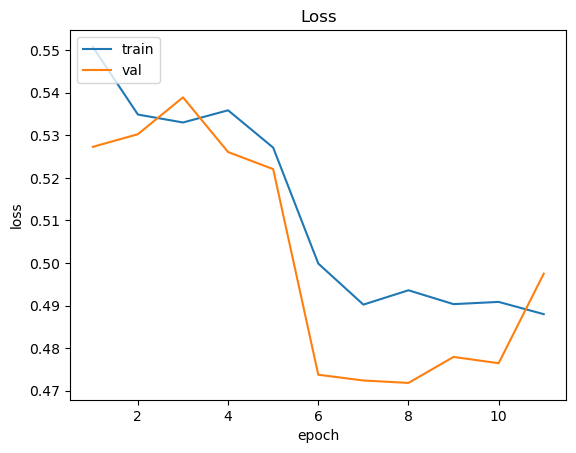

In [25]:
# draw Losses
if is_graphic:
  plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss, label="train")
  plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss, label="val")

  plt.title("Loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend(loc="upper left")

  plt.show()

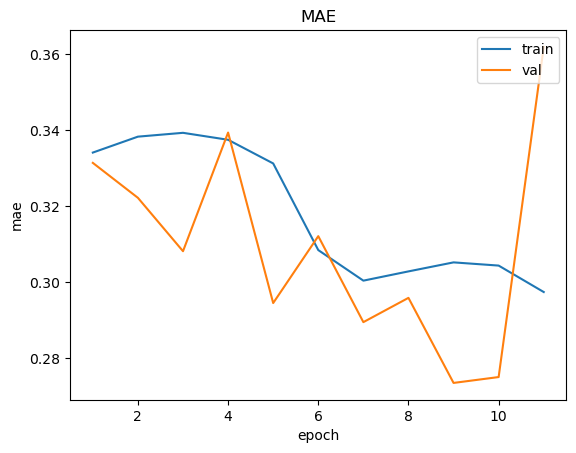

In [26]:
# draw mae
if is_graphic:
  plt.plot(list(range(1, len(arr_train_mae) + 1)), arr_train_mae, label="train")
  plt.plot(list(range(1, len(arr_val_mae) + 1)), arr_val_mae, label="val")

  plt.title("MAE")
  plt.xlabel("epoch")
  plt.ylabel("mae")
  plt.legend(loc="upper right")

  plt.show()

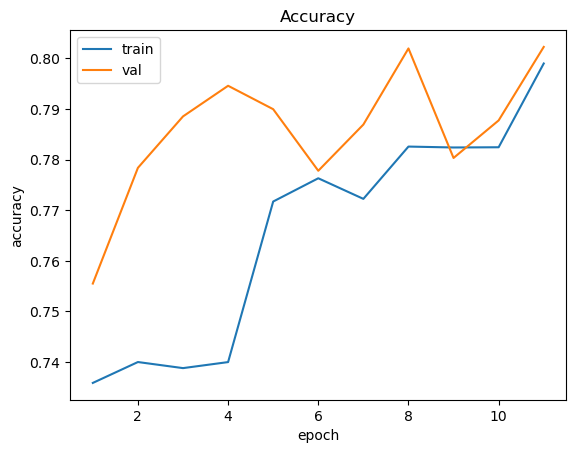

In [27]:
# draw Accuracies
if is_graphic:
  plt.plot(list(range(1, len(arr_train_acc) + 1)), arr_train_acc, label="train")
  plt.plot(list(range(1, len(arr_val_acc) + 1)), arr_val_acc, label="val")

  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend(loc="upper left")

  plt.show()

## Eval model

In [28]:
model = HeterSUMGraph(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings())

In [29]:
best_epoch = np.argmin(np.array(arr_val_loss)) + 1
model.load(checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt")
model.to(device)
model.eval()
best_epoch

8

In [30]:
df_test["doc_splitted"] = split_all_docs(df_test["docs"], False)
test_set = df_test

In [31]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
criterion = nn.BCELoss()
mae_fn = nn.L1Loss()

In [32]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
arr_loss = []
mae = []
accuracy = []

idx = 0

counter = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
  for batch in tepoch:
    tepoch.set_description("Eval model")
    data = batch["docs"].to(device)
    targets = torch.tensor(batch["labels"], dtype=torch.float).to(device)
    y_pred = model(data)

    loss = criterion(y_pred, targets)

    arr_loss.append(loss.item())

    doc = test_set["doc_splitted"].iloc[idx]
    summaries = test_set["summaries"].iloc[idx]

    probs = np.array(y_pred.tolist()) # compute_probs(y_pred)
    probs_tensor = y_pred #torch.tensor(probs, dtype=torch.float).to(device)

    #probs = threshold_probs_by_nb(probs=probs, doc_lens=[probs.shape[0]], average_number_of_sentences_per_document=average_number_of_sentences_per_document)
    #probs = threshold_probs_by_prop(probs=probs, doc_lens=[probs.shape[0]], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document)
    indices = torch.argsort(y_pred, descending=True)

    y_pred_thresh = []

    txt = ""

    for i in range(min(len(doc), y_pred.shape[0])):
      txt = txt + ". " + doc[indices[i]]
      y_pred_thresh.append(indices[i])
      if len(txt) >= len(summaries):
        break

    y_pred_thresh.sort()

    txt = ""

    for i in y_pred_thresh:#range(min(len(doc), y_pred.shape[0])):
      txt = txt + ". " + doc[i]

    n = min(len(txt), len(summaries))

    while n < len(txt) and txt[n].isalnum():
      n += 1

    txt = txt[:n]

    #assert len(txt) - len(summaries) <= 20

    scores = scorer.score(summaries, txt)
    arr_rouge1.append(scores["rouge1"].recall)
    arr_rouge2.append(scores["rouge2"].recall)
    arr_rougeL.append(scores["rougeL"].recall)

    mae.append(mae_fn(probs_tensor, targets).item())

    accuracy.append(accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=[len(probs)], average_number_of_sentences_per_document=average_number_of_sentences_per_document))
    #accuracy.append(accuracy_prop_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=[len(probs)], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document))

    tepoch.set_postfix(loss=np.mean(arr_loss), rouge1 = np.mean(arr_rouge1), rouge2 = np.mean(arr_rouge2), rougeL = np.mean(arr_rougeL), accuracy=np.mean(accuracy))
    idx += 1


Eval model: 100%|██████████| 100/100 [00:02<00:00, 34.00batch/s, accuracy=0.801, loss=0.473, rouge1=0.38, rouge2=0.168, rougeL=0.268]


In [33]:
test_metrics = {}
test_metrics["accuracy"] = np.mean(accuracy)
test_metrics["mae"]      = np.mean(mae)
test_metrics["rouge1"]   = np.mean(arr_rouge1)
test_metrics["rouge2"]   = np.mean(arr_rouge2)
test_metrics["rougeL"]   = np.mean(arr_rougeL)

# Save to file in JSON format

with open(checkpoints_folder + "/test_metrics.json", 'w') as fp:
  json.dump(test_metrics, fp)

### Lead-3

In [34]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
mae = []
accuracy = []

idx = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("Lead-3")
        doc = test_set["doc_splitted"].iloc[idx]

        txt = ""

        for i in range(min(len(doc), 3)):
            txt = txt + doc[i]

        summaries = test_set["summaries"].iloc[idx]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        scores = scorer.score(summaries, txt)
        arr_rouge1.append(scores["rouge1"].recall)
        arr_rouge2.append(scores["rouge2"].recall)
        arr_rougeL.append(scores["rougeL"].recall)

        idx += 1

        tepoch.set_postfix(rouge1 = np.mean(arr_rouge1), rouge2 = np.mean(arr_rouge2), rougeL = np.mean(arr_rougeL))

Lead-3: 100%|██████████| 100/100 [00:01<00:00, 95.15batch/s, rouge1=0.393, rouge2=0.217, rougeL=0.299]


### First n char

In [35]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
mae = []
accuracy = []

idx = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("First-n-char'")
        doc = test_set["doc_splitted"].iloc[idx]

        txt = ""

        for i in range(len(doc)):
            txt = txt + doc[i]

        summaries = test_set["summaries"].iloc[idx]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        scores = scorer.score(summaries, txt)
        arr_rouge1.append(scores["rouge1"].recall)
        arr_rouge2.append(scores["rouge2"].recall)
        arr_rougeL.append(scores["rougeL"].recall)

        idx += 1

        tepoch.set_postfix(rouge1 = np.mean(arr_rouge1), rouge2 = np.mean(arr_rouge2), rougeL = np.mean(arr_rougeL))

First-n-char': 100%|██████████| 100/100 [00:01<00:00, 90.24batch/s, rouge1=0.453, rouge2=0.25, rougeL=0.338]


In [36]:
# Does not execute this cell if you want to execute the following cells.
import sys
sys.exit()

SystemExit: 

/home/rsaid/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


: 